# Demo showing how to regrid tracks pixel cloudmask to ERA5 resolution

Uses ideas from `regrid_mask.ipynb`, as applied to real data.

In [1]:
import datetime as dt
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

from mcs_prime import PATHS, McsTracks

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
tracks = tracks = McsTracks.open(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                                 PATHS['pixeldir'])
tracks

McsTracks[2019-01-01 00:30:00, 2019-12-31 22:30:00, ntracks=32843]

In [3]:
figdir = Path('/home/users/mmuetz/tmp/regrid_pixel_to_era5')
figdir.mkdir(exist_ok=True, parents=True)

In [4]:
# Caches various netcdf fields for faster reruns.
native_path = figdir / 'cloudnumber_native_grid.nc'
mask_path = figdir / 'cloudnumber_ERA5_grid.nc'
regridder_path = figdir / 'bilinear_1200x3600_481x1440_peri.nc'

def clear_cache(paths):
    for path in [p for p in paths if p.exists()]:
        print(f'rm {path}')
        path.unlink()
        
# clear_cache([native_path, mask_path, regridder_path])

In [5]:
time = dt.datetime(2019, 1, 5, 0, 30)
pdtime = pd.Timestamp(time)

In [6]:
ts = tracks.tracks_at_time(time)
frame = ts.pixel_data.get_frame(time)
tmask = (ts.dstracks.base_time == pdtime).values
cns = ts.dstracks.cloudnumber.values[tmask]
cns.sort()

In [7]:
year = 2019
month = 1
day = 5
e5datadir = PATHS['era5dir'] / f'data/oper/an_sfc/{year}/{month:02d}/{day:02d}'
e5cape = xr.open_dataarray(e5datadir / f'ecmwf-era5_oper_an_sfc_{year}{month:02d}{day:02d}0000.cape.nc')
e5cape = e5cape.sel(latitude=slice(60, -60)).isel(time=0)
pixel_precip = frame.dspixel.precipitation.isel(time=0)

In [8]:
# N.B. caching values.
if regridder_path.exists():
    print('loading regridder')
    regridder = xe.Regridder(pixel_precip, e5cape, 'bilinear', periodic=True,
                             reuse_weights=True, weights=regridder_path)
else:
    # N.B. this is reasonably challenging.
    # * lat direction is different,
    # * ERA5 lon: 0--360, pixel lon: -180--180.
    print('generating regridder')
    regridder = xe.Regridder(pixel_precip, e5cape, 'bilinear', periodic=True)
    regridder.to_netcdf(regridder_path)
regridder

loading regridder


/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_1200x3600_481x1440_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (1200, 3600) 
Output grid shape:          (481, 1440) 
Periodic in longitude?      True

In [9]:
if native_path.exists():
    print('loading native cn data')
    cn_na = xr.open_dataarray(native_path)
else:
    frame.dspixel.cloudnumber.isin(cns).to_netcdf(native_path)

loading native cn data


In [10]:
if mask_path.exists():
    print('loading era5 cn data')
    cn_e5 = xr.open_dataarray(mask_path)
else:
    print('generating era5 cn data')
    mask_regridded = []
    for i in cns:
        print(i)
        mask_regridded.append(regridder((frame.dspixel.cloudnumber == i).astype(float)))

    da_mask_regridded = xr.concat(mask_regridded, pd.Index(cns, name='cn'))
    cn_e5 = ((da_mask_regridded > 0.5).astype(int) * da_mask_regridded.cn).sum(dim='cn')
    cn_e5.to_netcdf(mask_path)

loading era5 cn data


# Display masks for 1 day

In [11]:
# cn_e5 = xr.open_dataarray(mask_path)
# cn_na = xr.open_dataarray(native_path)
# (cn_e5 >= 1).plot()
def plot_cloudnumbers(frame, cn_e5, xlim=None, ylim=None):
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, sharey=True)
    fig.set_size_inches(20, 12)
    all_cn = frame.dspixel.cloudnumber.values.astype(int).copy()
    all_cn[np.isnan(frame.dspixel.cloudnumber.values)] = 0

    mcs_cn = frame.dspixel.cloudnumber.values.astype(int).copy()
    mcs_cn[np.isnan(frame.dspixel.cloudnumber.values)] = 0
    mcs_cn[~frame.dspixel.cloudnumber.isin(cns).values] = 0

    ax0.imshow(all_cn[0], extent=(-180, 180, -60, 60), origin='lower')
    ax1.imshow(mcs_cn[0], extent=(-180, 180, -60, 60), origin='lower')
    ax2.imshow(np.roll(cn_e5.values[0], 720, axis=1), extent=(-180, 180, -60, 60))
    
    ax0.set_title('All cloudnumbers, native res.')
    ax1.set_title('MCS cloudnumbers, native res.')
    ax2.set_title('MCS cloudnumbers, ERA5 res.')

    if xlim:
        ax0.set_xlim(xlim)
    if ylim:
        ax0.set_ylim(ylim)
    # N.B. Zoomed in on specific cloud mask to show interp.

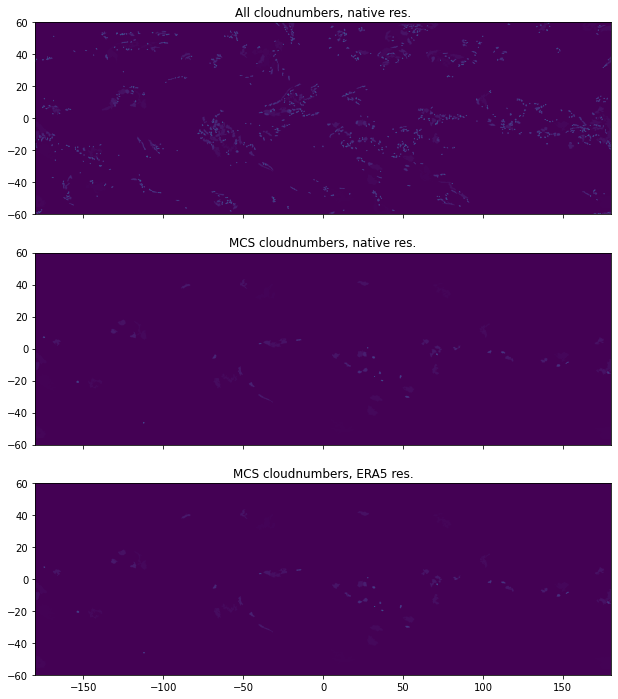

In [12]:
# Global. Note, the MCS dataset has all clouds tracked, and so showing all cloudnumbers
# shows a lot of clouds. Filtering it based on whether they are MCSs reduces this substantially.
plot_cloudnumbers(frame, cn_e5)

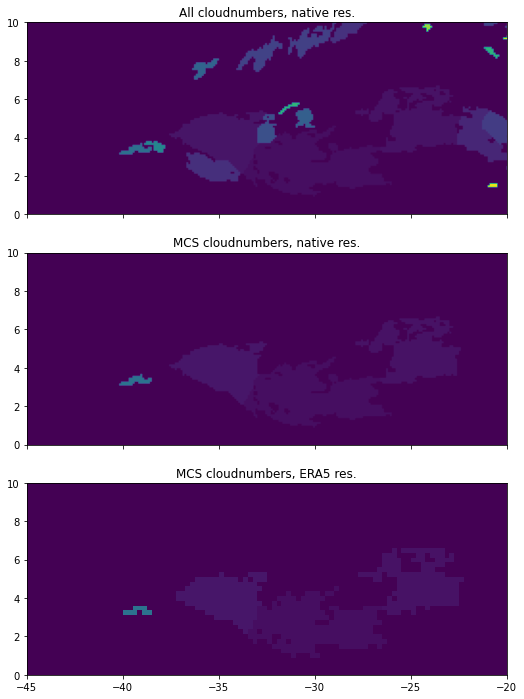

In [13]:
# Zoom on active area. Clearer to see which clouds are MCSs. Boundary between 
# touching clouds obvious, and seems to be well handled by coursening.
plot_cloudnumbers(frame, cn_e5, (-45, -20), (0, 10))

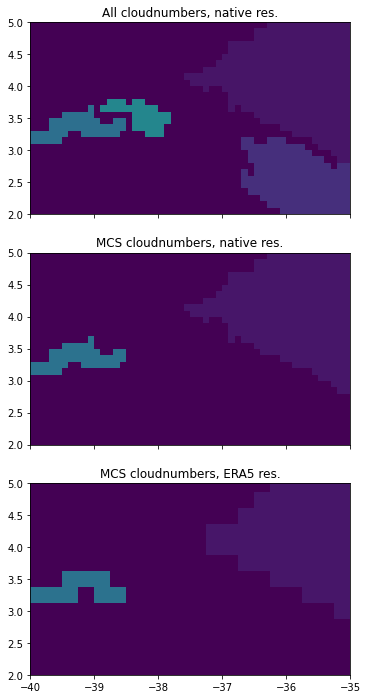

In [14]:
# Zoom on small area to show detail.
plot_cloudnumbers(frame, cn_e5, (-40, -35), (2, 5))

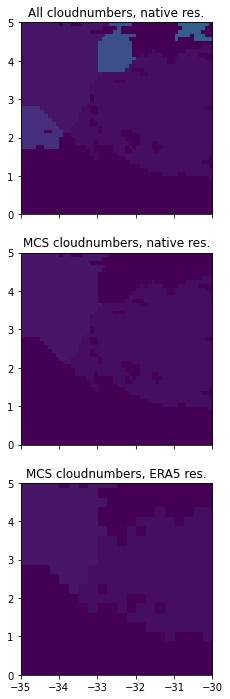

In [15]:
# Zoom on boundary between touching clouds.
plot_cloudnumbers(frame, cn_e5, (-35, -30), (0, 5))

# CAPE distributions in 3 regions: MCS, convecive and environment.

3 regions are mutually exclusive - i.e. convective points are only considered outside of MCSs.

In [16]:
mcs_mask = cn_e5.values[0] > 0.5

# Note much use!
# native_conv_mask = frame.dspixel.tb[0].values < 225
e5tb = regridder(frame.dspixel.tb)
# e5precip = regridder(frame.dspixel.precipitation)
# e5conv_mask = (e5tb[0] < 225) & (e5precip[0] > 10)
# N.B. Feng et al. 2021 uses Tb < 225 to define cold cloud cores.
e5conv_mask = e5tb[0] < 225

# The three masks used are mutually exclusive:
# mcs_mask -- all values within MCS CCS.
# ~mcs_mask & e5conv_mask -- all values not in MCS but in convective regions.
# ~mcs_mask & ~e5conv_mask -- env.
assert mcs_mask.sum() + (~mcs_mask & e5conv_mask).sum() + (~mcs_mask & ~e5conv_mask).sum() == mcs_mask.size

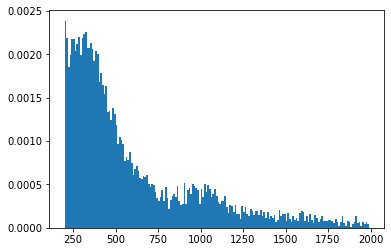

In [17]:
plt.hist(e5cape.values[mcs_mask], bins=np.arange(200, 2000, 10), density=True);

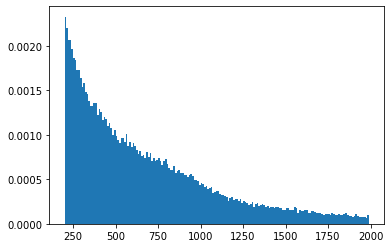

In [18]:
plt.hist(e5cape.values[~mcs_mask], bins=np.arange(200, 2000, 10), density=True);

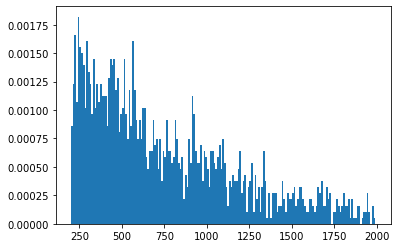

In [19]:
# N.B. want both area outside of mcs_mask, and in convective regions.
# just using e5conv_mask will select regions inside each MCS.
plt.hist(e5cape.values[~mcs_mask & e5conv_mask], bins=np.arange(200, 2000, 10), density=True);

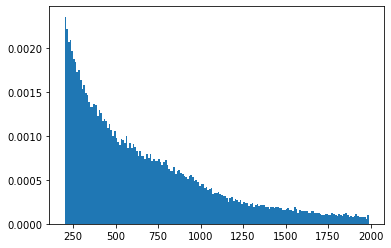

In [20]:
plt.hist(e5cape.values[~mcs_mask & ~e5conv_mask], bins=np.arange(200, 2000, 10), density=True);

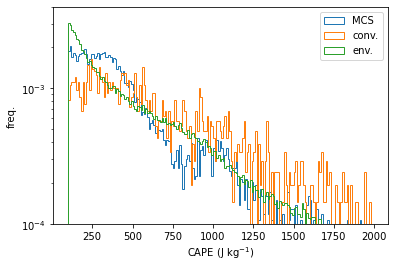

In [21]:
def cape_hist(**kwargs):
    # Closure over vars!
    ylim = kwargs.pop('ylim', None)
    plt.hist(e5cape.values[mcs_mask], **kwargs, label='MCS')
    plt.hist(e5cape.values[~mcs_mask & e5conv_mask], **kwargs, label='conv.')
    plt.hist(e5cape.values[~mcs_mask & ~e5conv_mask], **kwargs, label='env.')
    plt.legend()
    plt.xlabel('CAPE (J kg$^{-1}$)')
    plt.ylabel('freq.')
    if ylim:
        plt.ylim(ylim)
cape_hist(bins=np.arange(100, 2000, 10), density=True, histtype='step', log=True, ylim=(1e-4, 4e-3))

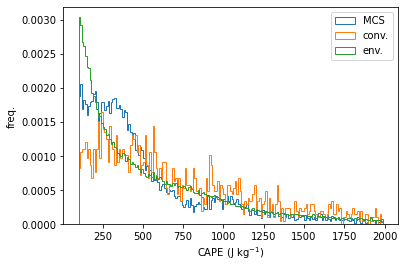

In [22]:
cape_hist(bins=np.arange(100, 2000, 10), density=True, histtype='step')

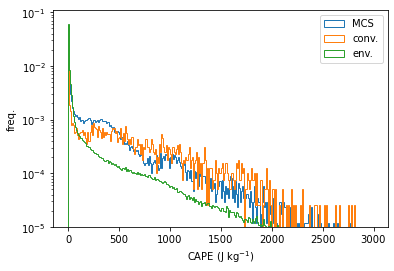

In [23]:
cape_hist(bins=np.arange(0, 3000, 10), density=True, histtype='step', log=True, ylim=(1e-5, None))

# Regrid to get *just* MCS vs non-MCS areas

Would give a big speed up if I don't need the information about which MCS is which MCS cloudnumber

In [24]:
e5mcs_mask = regridder(frame.dspixel.cloudnumber.isin(cns).astype(float)) > 0.5

In [28]:
# cn_e5 = xr.open_dataarray(mask_path)
# cn_na = xr.open_dataarray(native_path)
# (cn_e5 >= 1).plot()
def plot_cloudnumbers(frame, cn_e5, xlim=None, ylim=None):
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, sharey=True)
    fig.set_size_inches(20, 12)
    all_cn = frame.dspixel.cloudnumber.values.astype(int).copy()
    all_cn[np.isnan(frame.dspixel.cloudnumber.values)] = 0

    mcs_cn = e5mcs_mask.values

    ax0.imshow(all_cn[0], extent=(-180, 180, -60, 60), origin='lower')
    ax1.imshow(np.roll(mcs_cn[0], 720, axis=1), extent=(-180, 180, -60, 60))
    ax2.imshow(np.roll(cn_e5.values[0], 720, axis=1), extent=(-180, 180, -60, 60))
    
    ax0.set_title('All cloudnumbers, native res.')
    ax1.set_title('MCSs, ERA5 res.')
    ax2.set_title('MCS cloudnumbers, ERA5 res.')

    if xlim:
        ax0.set_xlim(xlim)
    if ylim:
        ax0.set_ylim(ylim)
    # N.B. Zoomed in on specific cloud mask to show interp.

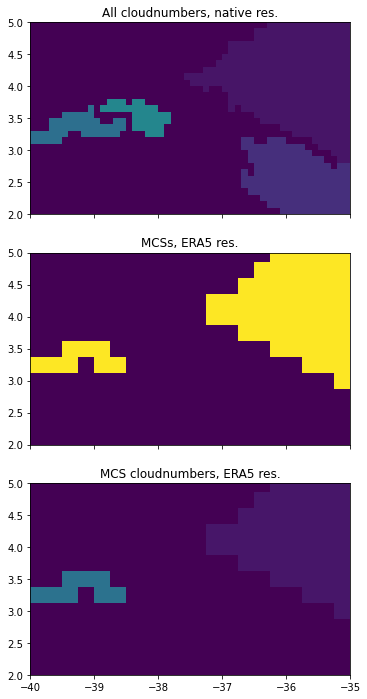

In [29]:
# Zoom on small area to show detail.
plot_cloudnumbers(frame, cn_e5, (-40, -35), (2, 5))

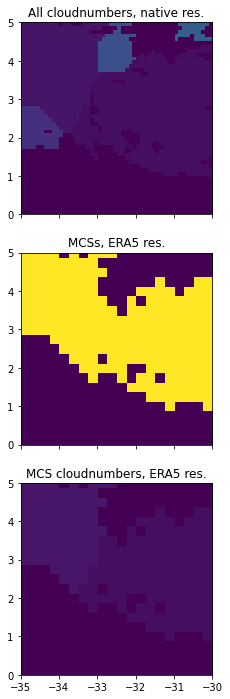

In [30]:
# Zoom on boundary between touching clouds.
plot_cloudnumbers(frame, cn_e5, (-35, -30), (0, 5))